<a href="https://colab.research.google.com/github/GlassesNoGlasses/TFProjects/blob/ethnicity_classifier/projects/classification/ethnicity/Ethnicity_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Clone repo

!git clone https://github.com/GlassesNoGlasses/TFProjects.git

Cloning into 'TFProjects'...
remote: Enumerating objects: 1780, done.
remote: Counting objects: 100% (1780/1780), done.
remote: Compressing objects: 100% (1502/1502), done.
remote: Total 1780 (delta 289), reused 1738 (delta 272), pack-reused 0
Receiving objects: 100% (1780/1780), 21.06 MiB | 11.98 MiB/s, done.
Resolving deltas: 100% (289/289), done.


In [1]:
# Reclone repo if needed

!rm -r TFProjects/
!git clone https://github.com/GlassesNoGlasses/TFProjects.git

rm: cannot remove 'TFProjects/': No such file or directory
Cloning into 'TFProjects'...
remote: Enumerating objects: 1789, done.
remote: Counting objects: 100% (1789/1789), done.
remote: Compressing objects: 100% (1509/1509), done.
remote: Total 1789 (delta 291), reused 1747 (delta 274), pack-reused 0
Receiving objects: 100% (1789/1789), 21.23 MiB | 22.34 MiB/s, done.
Resolving deltas: 100% (291/291), done.


In [2]:
# Add required imports

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
# File locations/directories

import os

# List of all ethnicities
ethnicities_subdirs = ['Caucasian', 'Asian', 'African']

# paths to training/testing dirs
test_data_path = "/content/TFProjects/projects/classification/ethnicity/Test"
train_data_path = "/content/TFProjects/projects/classification/ethnicity/Train"

# Return list of all files in a dir given path
def GetFiles(path: str) -> list[str]:
  if path == None or len(path) == 0:
    return []

  return os.listdir(path)

In [4]:
for ethnicity in ethnicities_subdirs:
  print(ethnicity)
  print(GetFiles(train_data_path + "/" + ethnicity))

Caucasian
['Shane_Phillips_0001.jpg', 'Greg_Hennigar_0001.jpg', 'Paul_Bremer_0001.jpg', 'b36.JPG', '52.JPG', '180.JPG', '189.JPG', 'Jonathan_Byrd_0001.jpg', 'Angela_Merkel_0001.jpg', 'b32.JPG', 'Kristin_Davis_0003.jpg', '144.JPG', '938.JPG', 'Tom_Reilly_0003.jpg', 'George_P_Bush_0001.jpg', '133.JPG', 'Hillary_Clinton_0001.jpg', '147.JPG', '136.JPG', '76.JPG', 'Robert_Blake_0001.jpg', 'person_0363.jpg', '41.JPG', 'Robert_Bullock_0002.jpg', 'b46.JPG', '103.JPG', 'b56.JPG', '160.JPG', 'Tony_Blair_0012.jpg', 'Tony_Blair_0007.jpg', 'Phil_Jackson_0001.jpg', 'David_Brown_0001.jpg', 'Matt_Morris_0001.jpg', 'John_Mayer_0003.jpg', 'Kristin_Davis_0002.jpg', 'Winona_Ryder_0019.jpg', '203.JPG', 'person_0980.jpg', 'person_0421.jpg', 'b29.JPG', 'Kevin_Marshall_0001.jpg', 'Walter_Woods_0001.jpg', '28.JPG', 'Larry_Harris_0001.jpg', 'Tony_Blair_0011.jpg', '140.JPG', 'Helen_Clark_0001.jpg', '64.JPG', 'Tony_Blair_0016.jpg', 'Robin_Cook_0002.jpg', 'Tony_Blair_0002.jpg', 'Alicia_Silverstone_0002.jpg', '928.

# Converting to NumPy:

We need the data to be in a processable form. Therefore, we shall convert each ethnicity into a NumPy array: [image_id, ethnicity_id].

After, we will convert NumPy arrays to tensors for TensorFlow.

In [5]:
# Convert ethnicities to numbers for easier processing

ethnicity_to_id = {'Unknown': 0, 'African': 1, 'Asian': 2, 'Caucasian': 3}
id_to_ethnicity = {0: 'Unknown', 1: 'African', 2: 'Asian', 3: 'Caucasian'}

# Label images with label. Return NumPy matrix (len(image_list, 2))
def LabelImages(image_list, label):
  label_list = np.full((len(image_list)), ethnicity_to_id[label])
  return np.stack((np.array(image_list), label_list), axis=1)


In [6]:
# Constants

BATCH_SIZE = 32
RANDOM_SEED = 123
IMG_HEIGHT = 256
IMG_WIDTH = 256


In [7]:
# Load dataset from directories

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_data_path,
    labels='inferred',
    batch_size=32,
    seed=RANDOM_SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_data_path,
    labels='inferred',
    batch_size=32,
    seed=RANDOM_SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)

Found 1651 files belonging to 3 classes.
Found 74 files belonging to 3 classes.


In [8]:
# View class names of split datasets

class_names = train_data.class_names
print(class_names)

['African', 'Asian', 'Caucasian']


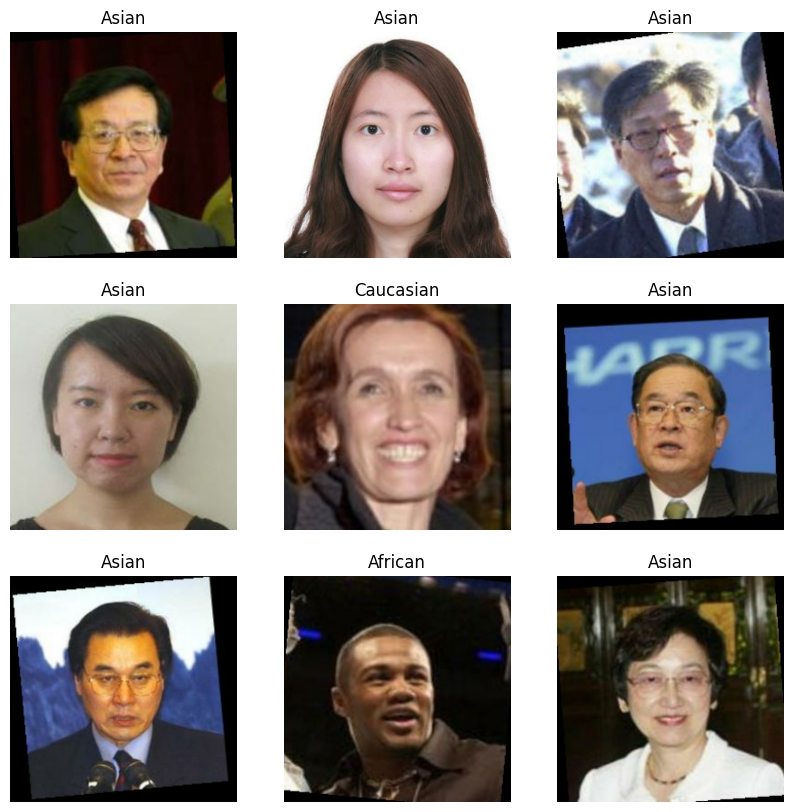

In [9]:
# Visualization of data being used

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Configurations & Prep

Now that we have our datasets in tf.Dataset format, we want to optimize the model training process.

In [10]:
# Cache the dataset and prefetch images

# Dataset.cache(): Caches dataset to save time and reduce bottleneck fetching
# Dataset.prefetch(): Prefetches next image during training/processing

# How many images to fetch for each batch
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
# Standardize RGB data

# AKA: Convert RGB [0, 255] to [0, 1] for easier processing
normalization_layer = layers.Rescaling(1./255)

# Overfitting Handling

We need to be cautious of our model potentially overfitting the training data due to the nature of image data.

We will use:

- Dropout Regularization.
- Data Augmentation

In [12]:
# augment data for more training variations

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(IMG_HEIGHT,
                                  IMG_WIDTH,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

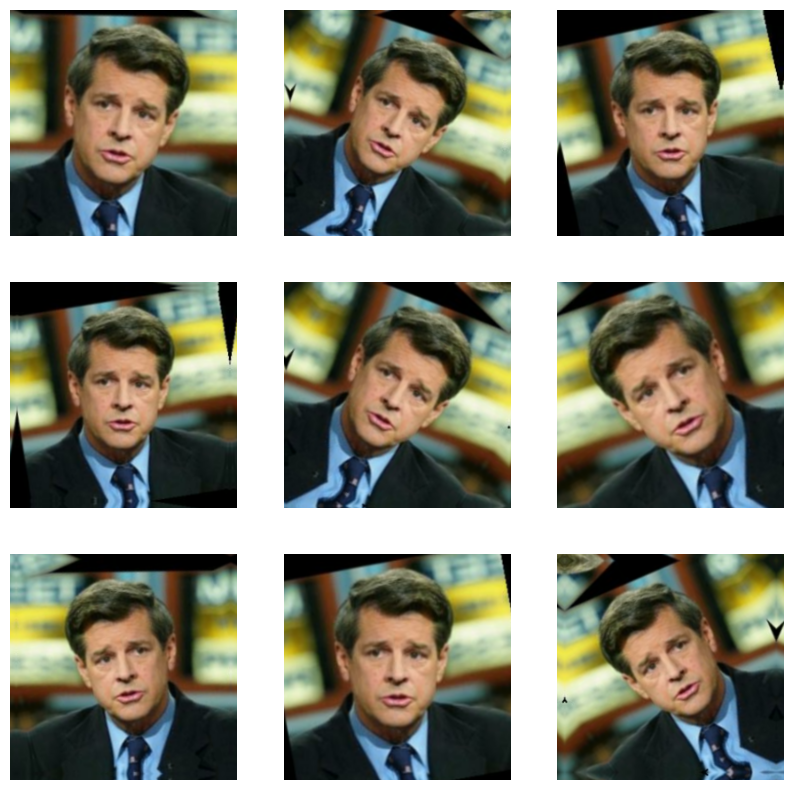

In [13]:
# Data Augmentation Visualization

plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Model Creation

Use standard 2D image processing, with our RGB rescaling and Dropout Regularization rate.

In [14]:
# Model Constants

NUM_CATEGORIES = len(class_names)
DROPOUT_PERCENTAGE = 0.2 # 20% dropout rate


In [15]:
# Creating the model

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(DROPOUT_PERCENTAGE),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(NUM_CATEGORIES, name="outputs")
])

In [16]:
# Compile model for accuracy
# Use built-in optimization and loss functions

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                 

In [18]:
# Train model

epochs = 15

history = model.fit(
  train_data,
  validation_data=test_data,
  epochs=epochs
)

Epoch 1/15
52/52 [==============================] - 12s 91ms/step - loss: 1.1242 - accuracy: 0.3943 - val_loss: 1.0178 - val_accuracy: 0.4324
Epoch 2/15
52/52 [==============================] - 3s 55ms/step - loss: 0.8814 - accuracy: 0.6008 - val_loss: 0.8922 - val_accuracy: 0.6216
Epoch 3/15
52/52 [==============================] - 3s 57ms/step - loss: 0.7623 - accuracy: 0.6602 - val_loss: 0.8080 - val_accuracy: 0.6351
Epoch 4/15
52/52 [==============================] - 3s 55ms/step - loss: 0.7064 - accuracy: 0.7050 - val_loss: 0.7614 - val_accuracy: 0.6351
Epoch 5/15
52/52 [==============================] - 3s 59ms/step - loss: 0.6963 - accuracy: 0.7075 - val_loss: 0.7594 - val_accuracy: 0.6486
Epoch 6/15
52/52 [==============================] - 3s 56ms/step - loss: 0.6656 - accuracy: 0.7147 - val_loss: 0.8124 - val_accuracy: 0.6622
Epoch 7/15
52/52 [==============================] - 3s 56ms/step - loss: 0.6263 - accuracy: 0.7353 - val_loss: 0.7586 - val_accuracy: 0.6351
Epoch 8/15
5

# Testing

In [23]:
# Load new test images from path

personal_test_path = "/content/TFProjects/projects/classification/ethnicity/PersonalTests"

personal_test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=personal_test_path,
    labels='inferred',
    batch_size=32,
    seed=RANDOM_SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)


Found 3 files belonging to 3 classes.


In [30]:
# Test on personal test data

model.predict(
    personal_test_data, batch_size=None, verbose='auto', steps=None, callbacks=None
)

1/1 [==============================] - 0s 22ms/step


array([[ 0.36501557,  0.7325974 ,  0.74097043],
       [ 4.0318775 , -1.2409495 ,  2.5099165 ],
       [ 1.6294336 ,  2.7500303 ,  1.3704953 ]], dtype=float32)